# Topic Modelling and sentiment analysis based on Machine Learning Reddit posts

The purpose of this project is to analyze the patterns in the textual data of reddit posts about machine learning

The dataset was obtained from Kaggle: https://www.kaggle.com/datasets/mathurinache/reddit-machine-learning-posts

Dataset description:

- title: topic of the discussion
- score: reddit score
- id: unique ID of each reddit post
- subreddit: subreddit topic
- url: link to the reddit post
- num_comments: number of comments
- body: the actual text of the post
- created: create timestamp
- timestamp: date and time of posting

The data contains 469 unique posts.

In this project we decided to perform data cleaning (removing stopwords, tokenization, TF-IDF matrix) and analysis of the most frequent words, applying sentiment analysis to each post and also an extensive tpic modelling analysis with LSA, LDA and BERTopic.

#### Importing the necessary packages

In [54]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_colwidth', 50)

import nltk
from nltk import word_tokenize

# get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
import re # for cleaning textual data (uses regular expressions ouch!)
from collections import Counter # for counting tokens occurences
import math # for calculations

import nltk
from nltk.tokenize import word_tokenize # for tokenization
from nltk.corpus import stopwords
from nltk.probability import FreqDist # for overall tokens frequency
from nltk.tokenize import RegexpTokenizer 

import gensim
from gensim import corpora # for: Dictionary(), word2bow()
from gensim import models # for: TfidfModel()

from nltk.tokenize import RegexpTokenizer # for LSA in sklearn, we will need additional tokenizer

from sklearn.feature_extraction.text import CountVectorizer # one can consider LSA with DF in DTM...
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM
from sklearn.decomposition import TruncatedSVD # this performs LSA!
from sklearn.decomposition import NMF # this performs NMF (or NNMF if you prefer)
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

import statistics # for: quantiles()
import time # for measuring time of computation
from collections import defaultdict # we will need it to easily track the number of unique tokens in corpus
import math

from bertopic import BERTopic




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Initial data cleaning and analysis

#### Loading the dataset

In [55]:
df = pd.read_csv('MachineLearning_reddit.csv')

#### Looking at the first few data rows

In [56]:
df.head()

,title,score,id,subreddit,url,num_comments,body,created,timestamp
0,[D] Simple Questions Thread,14,qorekl,MachineLearning,https://www.reddit.com/r/MachineLearning/comme...,54,Please post your questions here instead of cre...,1.636301e+09,2021-11-07 17:00:18
1,[P][R] Rocket-recycling with Reinforcement Lea...,607,qt2tws,MachineLearning,https://v.redd.it/enkc1p6oldz71,33,NaN,1.636815e+09,2021-11-13 15:52:07
2,[Project] PyTorch Implementations of 37 GAN pa...,334,qt10az,MachineLearning,https://i.redd.it/fjf94vuj4dz71.png,22,NaN,1.636809e+09,2021-11-13 14:13:18
3,[P] Using Talknet to clone Dreams' voice.,70,qt9yql,MachineLearning,https://v.redd.it/hmw9gpizefz71,19,NaN,1.636837e+09,2021-11-13 21:56:42
4,[R] StyleGAN of All Trades: Image Manipulation...,699,qsw47b,MachineLearning,https://i.redd.it/arv5dyfjfbz71.jpg,12,NaN,1.636789e+09,2021-11-13 08:31:19


#### Dataset information

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         469 non-null    object 
 1   score         469 non-null    int64  
 2   id            469 non-null    object 
 3   subreddit     469 non-null    object 
 4   url           469 non-null    object 
 5   num_comments  469 non-null    int64  
 6   body          387 non-null    object 
 7   created       469 non-null    float64
 8   timestamp     469 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 33.1+ KB


#### Removing NAs and checking how the dataset information looks like

In [58]:
df.dropna(inplace=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 466
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         387 non-null    object 
 1   score         387 non-null    int64  
 2   id            387 non-null    object 
 3   subreddit     387 non-null    object 
 4   url           387 non-null    object 
 5   num_comments  387 non-null    int64  
 6   body          387 non-null    object 
 7   created       387 non-null    float64
 8   timestamp     387 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 30.2+ KB


In [60]:
df.describe()

,score,num_comments,created
count,387.000000,387.000000,3.870000e+02
mean,33.932817,12.524548,1.635758e+09
std,79.166714,24.979397,6.806483e+05
min,0.000000,0.000000,1.634506e+09
25%,1.000000,1.000000,1.635216e+09
50%,5.000000,4.000000,1.635779e+09
75%,23.000000,10.000000,1.636386e+09
max,662.000000,211.000000,1.636879e+09


In [61]:
df.shape

(387, 9)

#### Score distribution

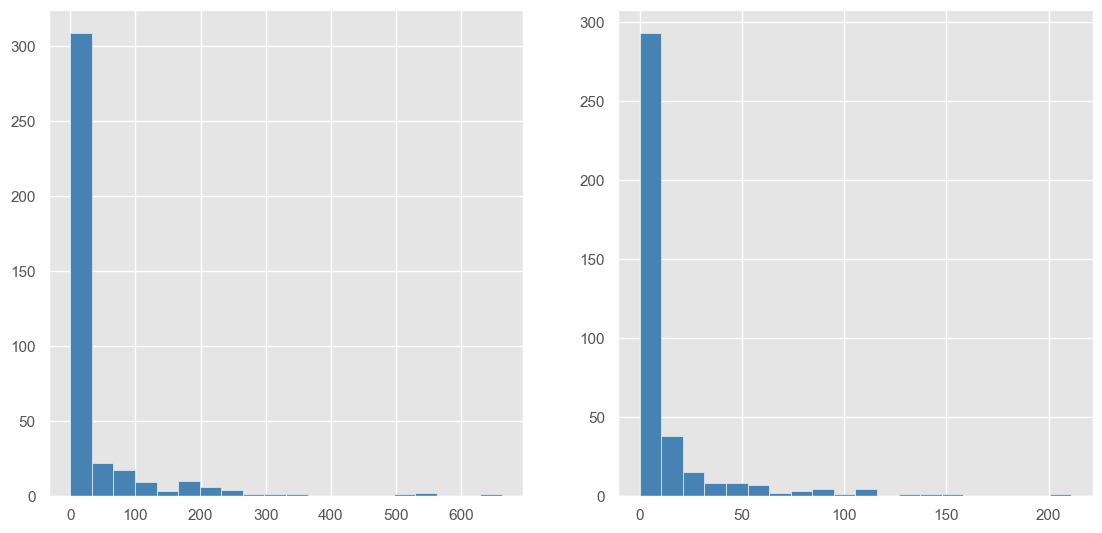

In [62]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)

plt.hist(df['score'], bins = 20, color = 'steelblue')

plt.subplot(1,2,2)

plt.hist(df['num_comments'], bins = 20, color = 'steelblue')
plt.show()

#### Text preprocessing

In [63]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Check if the value is a string
    if isinstance(text, str):
        pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        
        # Apply regex to remove links
        text = re.sub(pattern, '', text)
        
        # Tokenization
        tokens = word_tokenize(text.lower())  # Convert to lowercase during tokenization
        
        # Remove punctuation
        tokens = [word for word in tokens if word not in string.punctuation]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Join tokens back to a single string
        processed_text = ' '.join(tokens)
        
        return processed_text
    else:
        return str(text)  # Convert non-string values to string

processed_texts = df['body'].apply(lambda x: preprocess_text(x))

# Join all processed texts into a single string
all_text = ' '.join(processed_texts)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Most frequent words after preprocessing

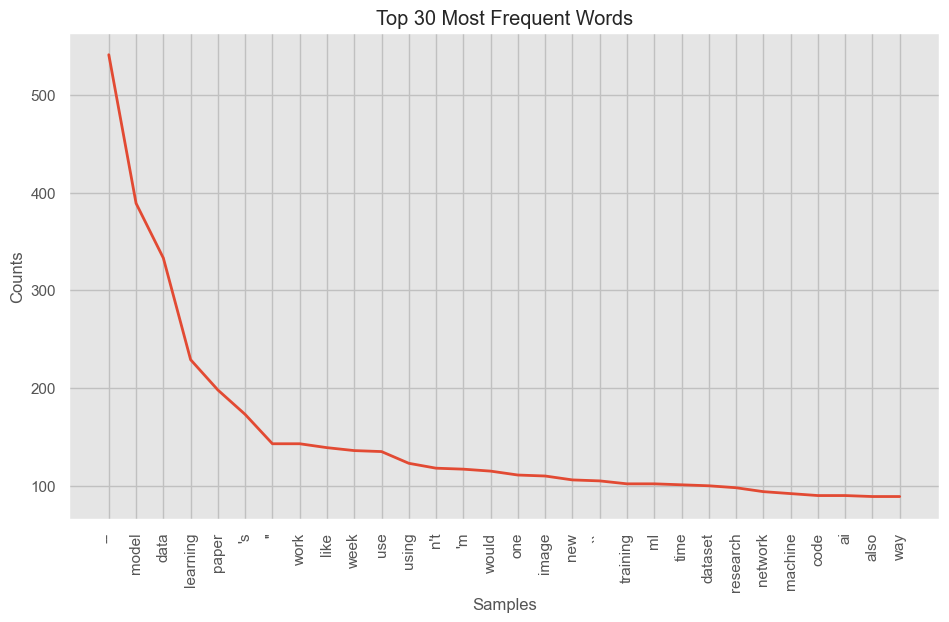

<AxesSubplot: title={'center': 'Top 30 Most Frequent Words'}, xlabel='Samples', ylabel='Counts'>

In [64]:
from nltk.probability import FreqDist

all_text = ' '.join(processed_texts)

tokens = all_text.split()
freq_dist = FreqDist(tokens)

plt.figure(figsize=(10, 6))
plt.title('Top 30 Most Frequent Words')
freq_dist.plot(30, cumulative=False)

#### Leaving only the subreddit and body columns

In [65]:
df = df[['subreddit','body' ]]
df = df.reset_index(drop = True)
df.head()



,subreddit,body
0,MachineLearning,Please post your questions here instead of cre...
1,MachineLearning,Hi!\r\n\r\nI am working on a time series probl...
2,MachineLearning,"Hello All,\r\n\r\nI have updated my ongoing Da..."
3,MachineLearning,We analysed the relationship between ICLR 2022...
4,MachineLearning,I created this demo in two days (last weekend)...


## Sentiment analysis

In [66]:

get_ipython().run_line_magic('time', '# to calulate the time it takes the algorithm to compute a VADER score')
i=0 # counter

compval1 = [ ] # empty list to hold our computed 'compound' VADER scores

while (i<len(df)):

    k = analyser.polarity_scores(str(df.iloc[i]['body']))
    compval1.append(k['compound'])
    
    i = i+1
    
# convert sentiment values to numpy for easier usage
compval1 = np.array(compval1)
df['VADER score'] = compval1

CPU times: total: 0 ns
Wall time: 0 ns


In [67]:
get_ipython().run_line_magic('time', '')

# assign score categories and logic
i = 0

predicted_value = [ ] # empty series to hold our predicted values

while(i<len(df)):
    if ((df.iloc[i]['VADER score'] >= 0.7)):
        predicted_value.append('positive')
        i = i+1
    elif ((df.iloc[i]['VADER score'] > 0) & (df.iloc[i]['VADER score'] < 0.7)):
        predicted_value.append('neutral')
        i = i+1
    elif ((df.iloc[i]['VADER score'] <= 0)):
        predicted_value.append('negative')
        i = i+1



CPU times: total: 0 ns
Wall time: 0 ns


<AxesSubplot: xlabel='predicted sentiment'>

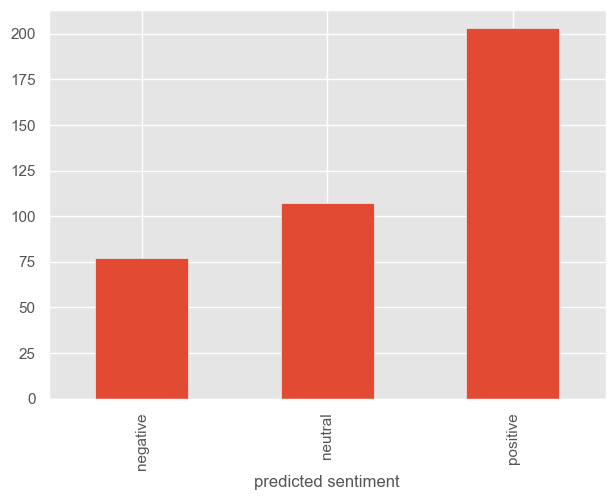

In [68]:

df['predicted sentiment'] = predicted_value

df.groupby('predicted sentiment').size().plot(kind='bar')



#### Creating a wordcloud to see the most frequent words again

In [69]:

# some basic visualization
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 

df_neg = df[df['predicted sentiment']=='negative']

words = ' '.join(df['body'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

stopwords = set(STOPWORDS)


wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)



In [70]:


df_neg = df[df['predicted sentiment']=='negative']

words = ' '.join(df['body'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

stopwords = list(STOPWORDS)
stopwords.append("model")
stopwords.append("learning")
stopwords.append("training")
stopwords.append("data")
stopwords.append("paper")
stopwords.append("image")
stopwords.append("problem")
stopwords.append("machine")
stopwords += ['patient','use', 'using', 'reddit', 'https', 'www', 'make', 'know', 'new', 'one', 'will']

wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

In [71]:
type(cleaned_word)

str

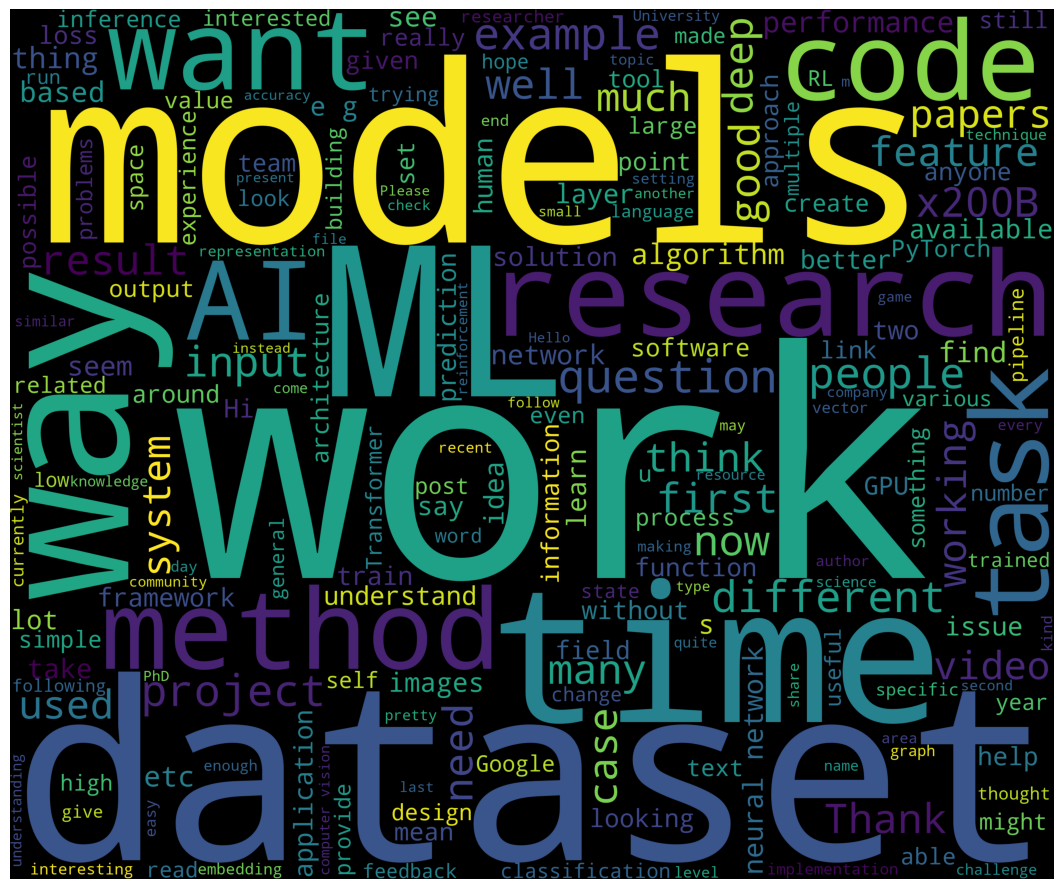

In [72]:

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


## Topic modelling

#### Further preprocessing: TF-IDF matrix and preparation of the models

In [73]:
tokenizer = RegexpTokenizer(r'\w+') # tokenizer
stopwords.append('oh')
stopwords.append('use')
stopwords.append('using')
stopwords.append('are')

# more about CountVectorizer(): https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#examples-using-sklearn-feature-extraction-text-countvectorizer
tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tfidf_vectorizer = TfidfVectorizer(encoding = 'utf-8', # if bytes to analyze, this encoding will be used
                                   decode_error = 'strict', # if we want to get an error in case of encoding error
                                   strip_accents = None, # if we want to do something we accents
                                   
                                   lowercase = True, # all letters to lower case 
                                   stop_words = stopwords, # what stopwords do we want to use 
                                   ngram_range = (1, 3), # what kind of ngrams do we want 
                                   
                                   max_df = 0.8, # filtering with document frequency
                                   min_df = 2, # filtering with document frequency
                                   max_features = None, # if we want to use only the tokens with top document frequency
                                   
                                   tokenizer = tokenizer.tokenize # tokenizer
)

tfidf = tfidf_vectorizer.fit_transform(df['body']) # using raw data for now
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out() # feature names

In [74]:
def plot_top_words(model, feature_names, n_top_words, title = '', subplotx = 2, subploty = 5):
    fig, axes = plt.subplots(subplotx, subploty, figsize=(60, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=30)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=1.5, bottom=0.05, wspace=2.5, hspace=0.3)
    plt.show()

#### LSA

In [96]:


tf = tfidf_vectorizer.fit_transform(df['body'])
tf_feature_names = tfidf_vectorizer.get_feature_names_out()

lsa = TruncatedSVD(n_components = 16, 
                   n_iter = 25,
                   random_state = 42)

model = lsa.fit_transform(tf)

for index, component in enumerate(lsa.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index)+": ",top_terms_list)



Topic 0:  ['s', 'png', 'github', 'arxiv', 'ai', 'models', 'org', 'm', 'format', 't']
Topic 1:  ['png', 'auto webp', 'auto webp s', 'preview redd', 'webp', 'webp s', 'width', 'preview', 'format png', 'format png auto']
Topic 2:  ['arxiv', 'arxiv org', 'abs', 'arxiv org abs', 'org abs', 'org', '2110', 'abs 2110', 'org abs 2110', 'rl']
Topic 3:  ['pdf', 'gan', 'casualganpapers', 'twitter', 'explained html', 'explained', 'html', 'casual', 't', 'style']
Topic 4:  ['ai', 'twitter', '3d', 'casualganpapers', 'gan', '2021', 'blog', 'html', 'style', 'deepmind']
Topic 5:  ['ai', 'ml', 'blog', 'questions', 'us', 'post', 'research', 'models', 'language', 'org']
Topic 6:  ['pytorch', 'models', 'github', '0', 'dataset', '1', '2', 'inference', 'video', 'gpu']
Topic 7:  ['youtube', 'video', 'v', 'watch', 'watch v', 'youtube watch', 'youtube watch v', 'dataset', 'ai', 'pdf']
Topic 8:  ['3d', 'ml', 'pdf', 'video', 'quality', 'computer', 'inference', 'vision', 'm', 'computer vision']
Topic 9:  ['pytorch',

In [97]:
lda = LatentDirichletAllocation(n_components = 16, 
                   random_state = 42)

model = lda.fit_transform(tf)

for index, component in enumerate(lda.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index)+": ",top_terms_list)



Topic 0:  ['license', 'discriminator', 'classifier', 'window', 'thread', 'questions', 'groups', 'post', 'customer', 'blog']
Topic 1:  ['share', 'docker', 'alphafold', 'masters', 'movie', 'thesis', 'structure', 'entropy', 'cnns', 'science']
Topic 2:  ['analytics', 'x', 'platforms', 'systems', 'making', 'jax', 'science', 'pre', 'reference', 'academia']
Topic 3:  ['deepmind', 'rl', 'cost', 'ru', 'low cost', 'syncedreview', 'quick read', 'based rl', 'low', 'rl frameworks']
Topic 4:  ['rl', 'reinforcement', 'optimizer', 'query', 'synthetic', 'kaggle', 'time', 'service', 'neurons', 'environment']
Topic 5:  ['metrics', 'someone', 'features', 'time', 'video', 'zero', 'file', 'openreview', 'specific', 'provide']
Topic 6:  ['e g', 'g', 'e', 'm', 'output', 'deep', 'computer', 'network', 'high', 'methods']
Topic 7:  ['book', 'functions', 'edition', 'things', 'healthcare', 'reviews', 'discussion', 'skimmed', 'year', 'api']
Topic 8:  ['article', 'good enough', 'available', 'video', 'bounding box', '

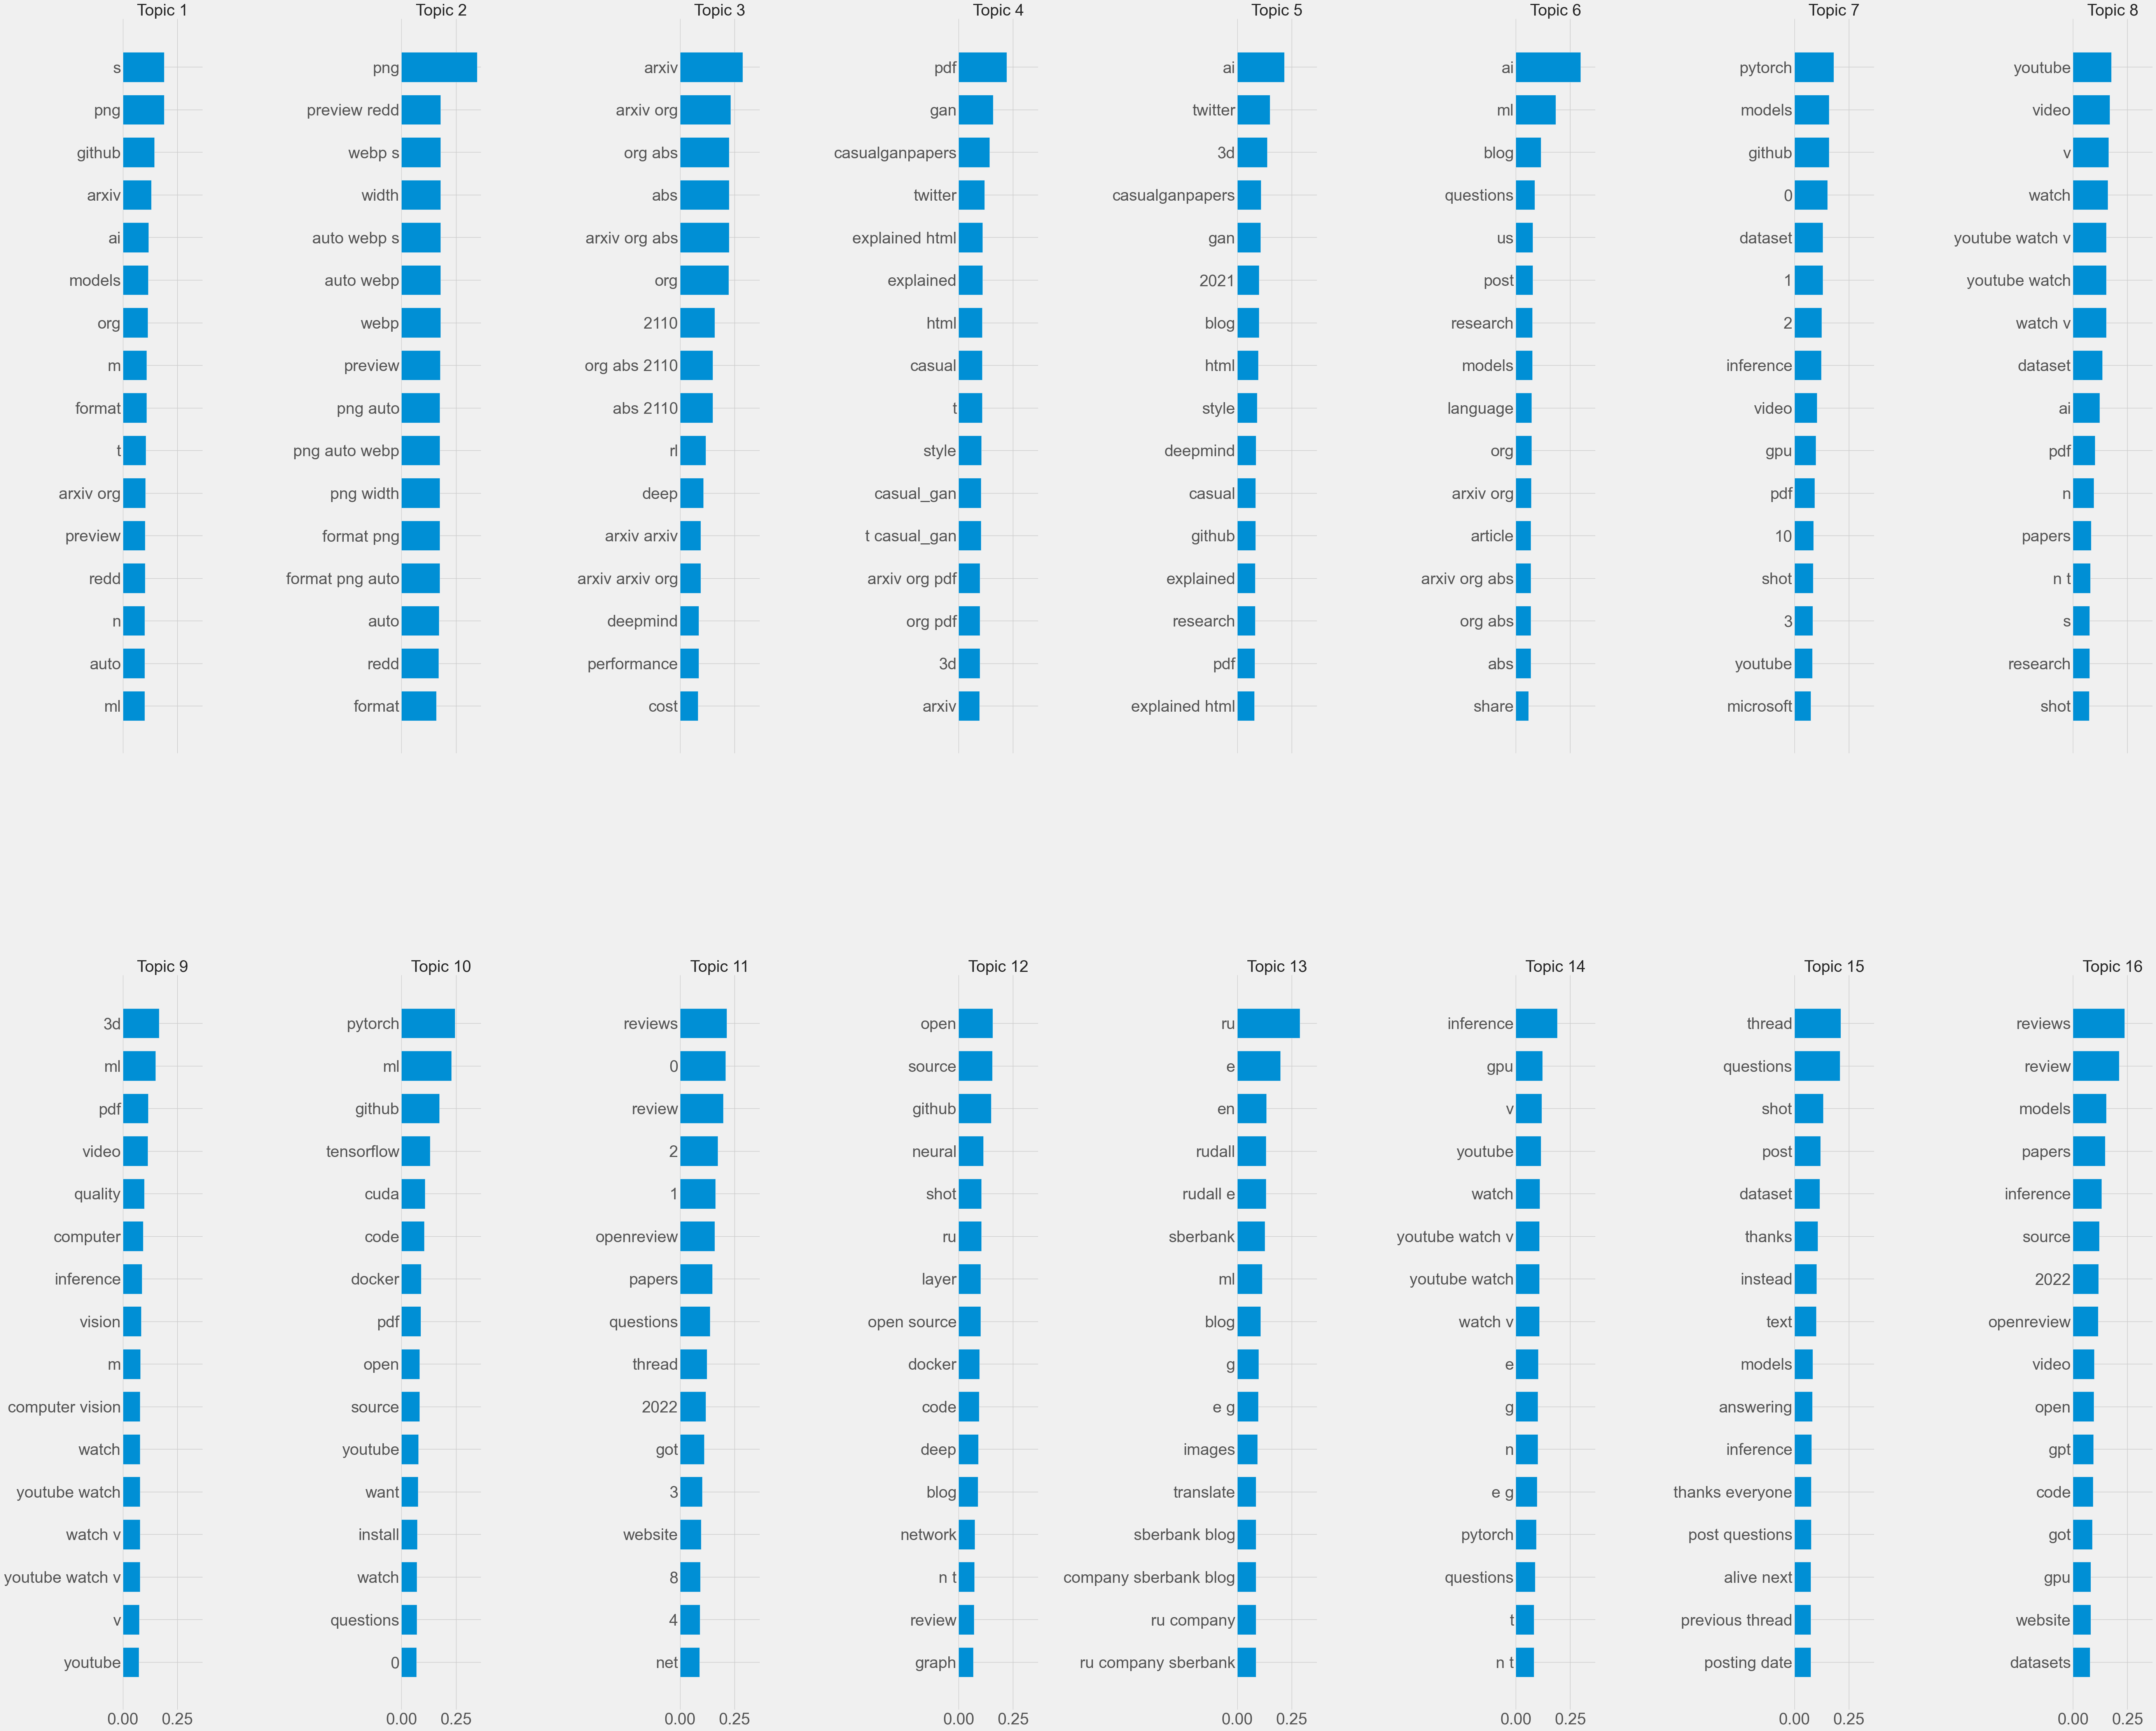

In [98]:
plot_top_words(lsa, tf_feature_names, 16, title = '', subplotx = 2, subploty = 8)

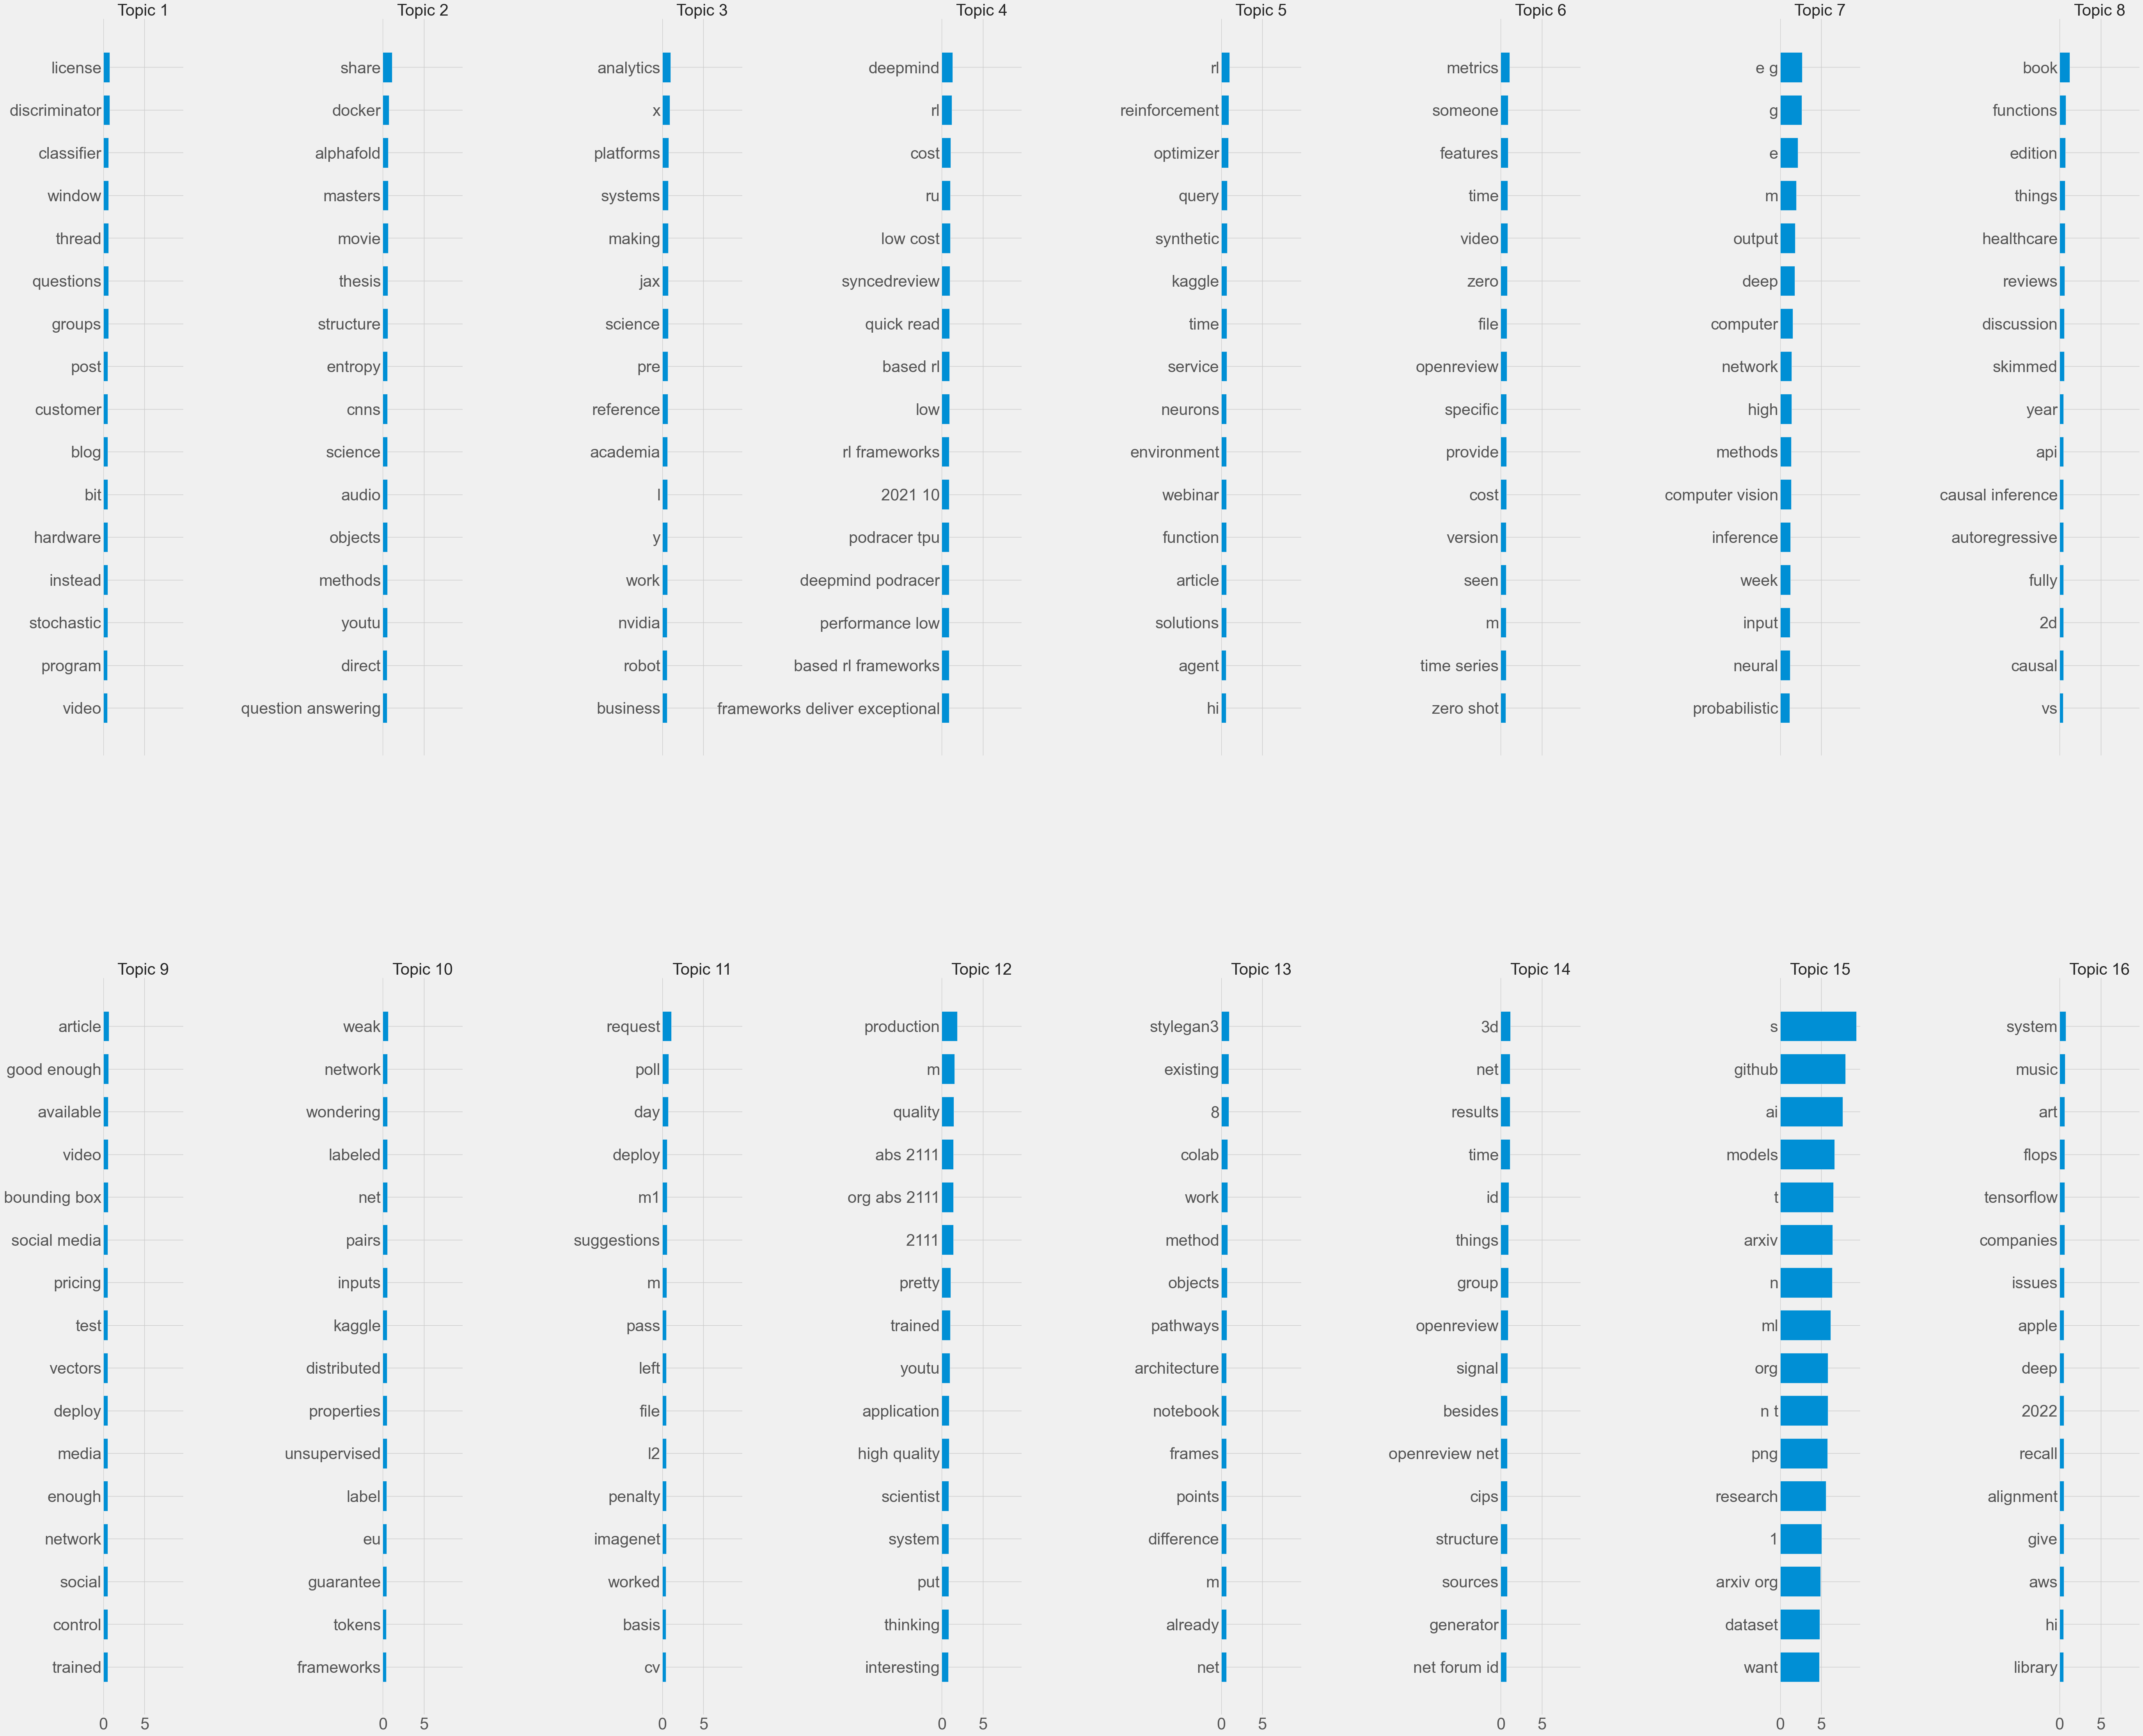

In [99]:
plot_top_words(lda, tf_feature_names, 16, title = '', subplotx = 2, subploty = 8)

In [100]:


# add a column to the original data frame that will store the topic for the text
topic_values = lda.transform(tf)
topic_values.shape




# add a new column for topic in the data frame and assigns the topic value to each row in the column
df['Topic_LDA'] = topic_values.argmax(axis=1)


topic_values = lsa.transform(tf)
topic_values.shape
# add a new column for topic in the data frame and assigns the topic value to each row in the column
df['Topic_LSA'] = topic_values.argmax(axis=1)

df.head()



,subreddit,body,VADER score,predicted sentiment,Topic_LDA,Topic_LSA,Topic_BERT
0,MachineLearning,Please post questions instead creating thread ...,0.9323,positive,0,14,12
1,MachineLearning,Hi ! I working time series I need test histori...,0.3802,neutral,4,0,8
2,MachineLearning,"Hello All , I updated ongoing Data Science boo...",0.8313,positive,14,0,7
3,MachineLearning,We analysed relationship ICLR 2022 review scor...,0.9599,positive,14,1,4
4,MachineLearning,"I created demo two days ( last weekend ) , cre...",0.8591,positive,14,5,10


(array([234.,  23.,  12.,  18.,  15.,   9.,  26.,  10.,  17.,  23.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

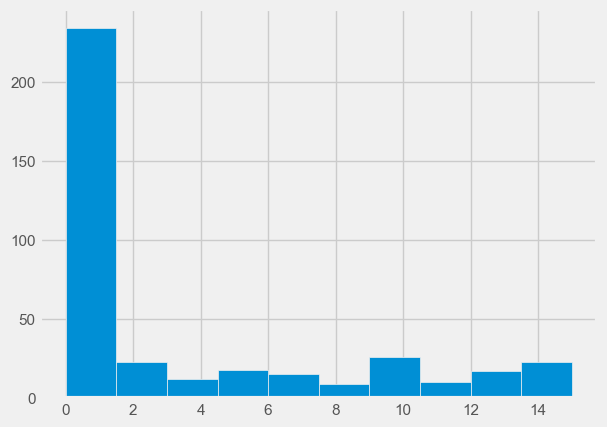

In [101]:
plt.hist(df['Topic_LSA'])

(array([ 37.,  16.,  44.,  22.,  41.,  15.,  29.,  25.,  43., 115.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

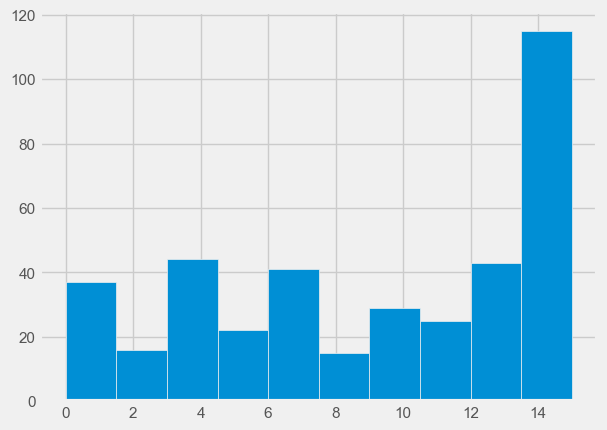

In [102]:
plt.hist(df['Topic_LDA'])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25


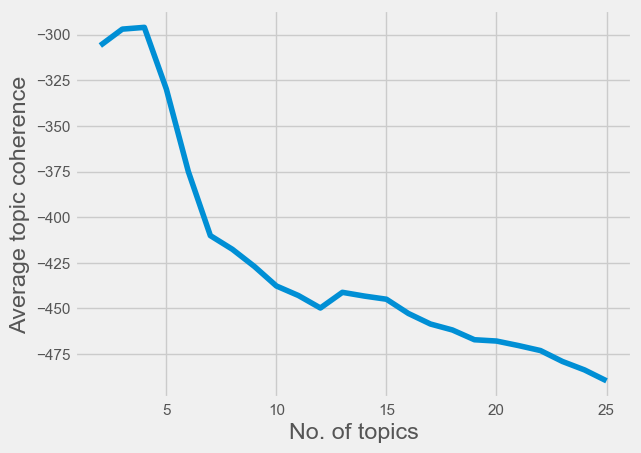

In [103]:
tf = tfidf_vectorizer.fit_transform(df['body'])
f_feature_names = tfidf_vectorizer.get_feature_names_out()

topic_coherence_specific = []

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

for n_topics in range(2,26,1):
    
    print('Trying parameters:', n_topics)
    
    lsa = TruncatedSVD(n_components = n_topics, n_iter = 25, random_state = 42) 
    #less iterations used above to not wait till tomorrow, results will be less precise though
                
    lsa.fit_transform(tf)
                
    avg_coherence = get_average_topic_coherence(tf, lsa.components_, 25)
    
    topic_coherence_specific.append([avg_coherence, n_topics])
# below, we make the output (list) a pandas DataFrame with intuitive colnames
topic_coherence_specific_df = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_df['n_topics'],topic_coherence_specific_df['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

## BERTopic

In [104]:
# df = pd.read_csv('MachineLearning_reddit.csv')
def generate_ngrams(text, ngram = 1):
    temp = zip(*[text[i:] for i in range(0,ngram)]) # set with pairs, three, ..., ns of tokens
    ans = [' '.join(ngram) for ngram in temp] # joins the elements in strings
    ans = pd.Series(ans).map(lambda x: re.sub(" ", '_', x)) # replaces spaces with '_'
    return list(ans)

def remove_stopwords(lists):
    lemmatizer = WordNetLemmatizer()

    lemmatized_stop_words = set([lemmatizer.lemmatize(word) for word in stop_words])
    return [word for word in lists if word not in lemmatized_stop_words]

# stop_words = set(nltk.corpus.stopwords.words('english'))
for i in range(len(df['body'])):
    df['body'][i] = word_tokenize(df['body'][i]) 
    

for i in range(len(df['body'])):
    filtered_sentence = [] 
    for w in df['body'][i]: 
        if w not in stopwords: 
            filtered_sentence.append(w) 
    df['body'][i] = filtered_sentence



In [105]:
df['body']

0      [Please, post, questions, instead, creating, t...
1      [Hi, !, I, working, time, series, I, need, tes...
2      [Hello, All, ,, I, updated, ongoing, Data, Sci...
3      [We, analysed, relationship, ICLR, 2022, revie...
4      [I, created, demo, two, days, (, last, weekend...
                             ...                        
382    [I, biased, ``, Good, Customers, ``, need, pre...
383    [A, research, team, University, Southern, Cali...
384    [I, finally, managed, train, Pytorch, OpenCL, ...
385    [Hi, everyone, ,, Wanted, share, Colab, notebo...
386    [Paper, :, [, Frozen, Time, :, A, Joint, Video...
Name: body, Length: 387, dtype: object

In [106]:
for i in range(len(df['body'])):
    df['body'][i] = " ".join(df['body'][i]) 

In [107]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, min_topic_size = 2, nr_topics = 16)
topics, probs = topic_model.fit_transform(df['body'])

bert_document_info = pd.DataFrame(topic_model.get_document_info(df['body']))

2024-01-31 18:08:25,555 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2024-01-31 18:09:20,515 - BERTopic - Embedding - Completed ✓
2024-01-31 18:09:20,516 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-31 18:09:24,296 - BERTopic - Dimensionality - Completed ✓
2024-01-31 18:09:24,296 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-31 18:09:24,462 - BERTopic - Cluster - Completed ✓
2024-01-31 18:09:24,462 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-31 18:09:24,662 - BERTopic - Representation - Completed ✓
2024-01-31 18:09:24,662 - BERTopic - Topic reduction - Reducing number of topics
2024-01-31 18:09:24,795 - BERTopic - Topic reduction - Reduced number of topics from 54 to 16


In [108]:
df['Topic_BERT'] = bert_document_info['Topic']

In [109]:
print(set(topics))

topic_info = topic_model.get_topic_info()
# print(topic_info)
topic_info


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}


,Topic,Count,Name,Representation,Representative_Docs
0,-1,58,-1_models_analytics_cm1_the,"[models, analytics, cm1, the, nt, book, cm2, m...","[To oversimplify , reality frequently covariat..."
1,0,94,0_ai_request_the_research,"[ai, request, the, research, language, this, s...",[This hypothesis highly related presentations ...
2,1,52,1_we_ml_issues_models,"[we, ml, issues, models, gpu, production, infe...","[Hello ML community , I wanted quick feedback ..."
3,2,48,2_network_the_neural_gan,"[network, the, neural, gan, deep, networks, fu...",[I 've recently read bunch literature network ...
4,3,37,3_dataset_images_datasets_videos,"[dataset, images, datasets, videos, music, met...",[Paper : [ Frozen Time : A Joint Video Image E...
5,4,28,4_autowebp_pytorch_x200b_formatpng,"[autowebp, pytorch, x200b, formatpng, rudalle,...",[I finally managed train Pytorch OpenCL severa...
6,5,26,5_week_openreviewnetforum_review_papers,"[week, openreviewnetforum, review, papers, rev...",[ICLR 2022 reviews publicly available now . We...
7,6,8,6_score_clusters_anomaly_unsupervised,"[score, clusters, anomaly, unsupervised, silho...",[I trying cluster mixed dataset numerical cate...
8,7,7,7_phd_salary_ml_experience,"[phd, salary, ml, experience, years, research,...",[Looking advice transition research-related ca...
9,8,7,8_disease_heart_home_results,"[disease, heart, home, results, run, makes, ca...",[I ’ m working product primarily uses name cla...


In [110]:
try:
    topic_model.visualize_topics()
except Exception as e:
    print(f"An error occurred during visualization: {e}")

topic_model.visualize_topics()

In [111]:

for i in range(min(5, len(topic_model.get_topics()))):
    print(f"Topic {i}: {topic_model.get_topic(i)}")

Topic 0: [('ai', 0.018694105012210332), ('request', 0.01820753165815424), ('the', 0.015836585245759358), ('research', 0.015379240339251012), ('language', 0.014441050863392887), ('this', 0.013268032847123022), ('solution', 0.013157591528787803), ('work', 0.0120268650506482), ('models', 0.01201991976109586), ('r1', 0.0110193845319678)]
Topic 1: [('we', 0.034077753086223926), ('ml', 0.03221338657942071), ('issues', 0.029441348305986836), ('models', 0.028571000438829007), ('gpu', 0.02390049682816667), ('production', 0.021255011450017316), ('inference', 0.021073589605555876), ('software', 0.01965336777437544), ('docker', 0.018406683585799485), ('running', 0.01626536808598762)]
Topic 2: [('network', 0.03196190247636683), ('the', 0.023359686480413994), ('neural', 0.02123235804824595), ('gan', 0.018985947809874924), ('deep', 0.01589980097438139), ('networks', 0.015299521891216554), ('function', 0.014946591266791568), ('different', 0.013508159157280533), ('images', 0.01333533981013346), ('input

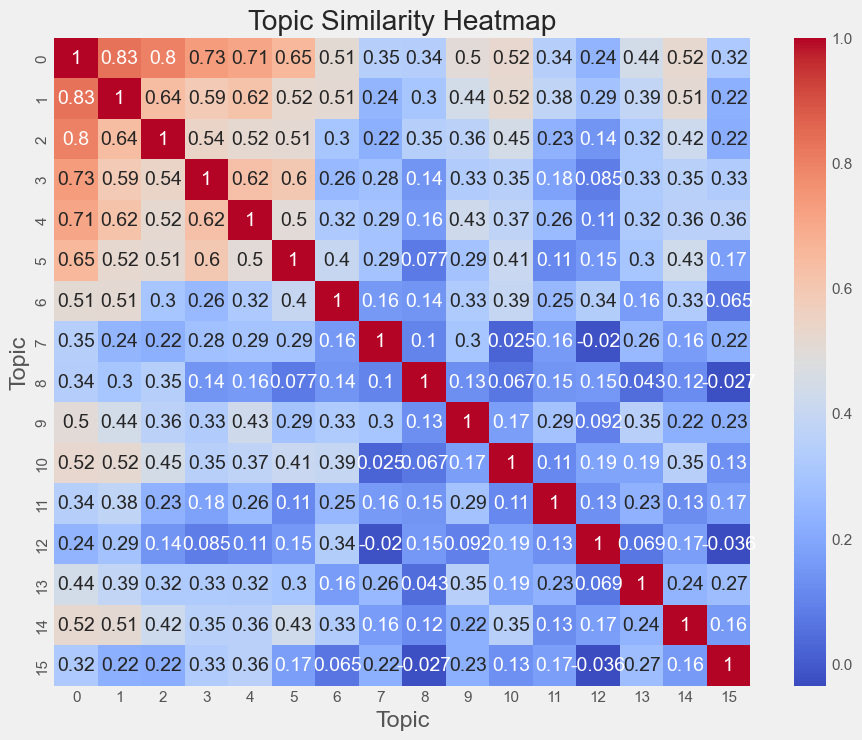

In [112]:
similarity_matrix = cosine_similarity(topic_model.topic_embeddings_)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
plt.title("Topic Similarity Heatmap")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()


In [113]:
try:
    topic_model.visualize_barchart()
except Exception as e:
    print(f"An error occurred during barchart visualization: {e}")

topic_model.visualize_barchart()

## Comparison of different models

In [114]:
df

,subreddit,body,VADER score,predicted sentiment,Topic_LDA,Topic_LSA,Topic_BERT
0,MachineLearning,Please post questions instead creating thread ...,0.9323,positive,0,14,11
1,MachineLearning,Hi ! I working time series I need test histori...,0.3802,neutral,4,0,12
2,MachineLearning,"Hello All , I updated ongoing Data Science boo...",0.8313,positive,14,0,-1
3,MachineLearning,We analysed relationship ICLR 2022 review scor...,0.9599,positive,14,1,5
4,MachineLearning,"I created demo two days ( last weekend ) , cre...",0.8591,positive,14,5,9
...,...,...,...,...,...,...,...
382,MachineLearning,I biased `` Good Customers `` need predictor g...,-0.2611,negative,5,8,-1
383,MachineLearning,A research team University Southern California...,0.5106,neutral,14,2,0
384,MachineLearning,I finally managed train Pytorch OpenCL several...,0.5213,neutral,14,9,4
385,MachineLearning,"Hi everyone , Wanted share Colab notebook I th...",0.9774,positive,12,0,-1


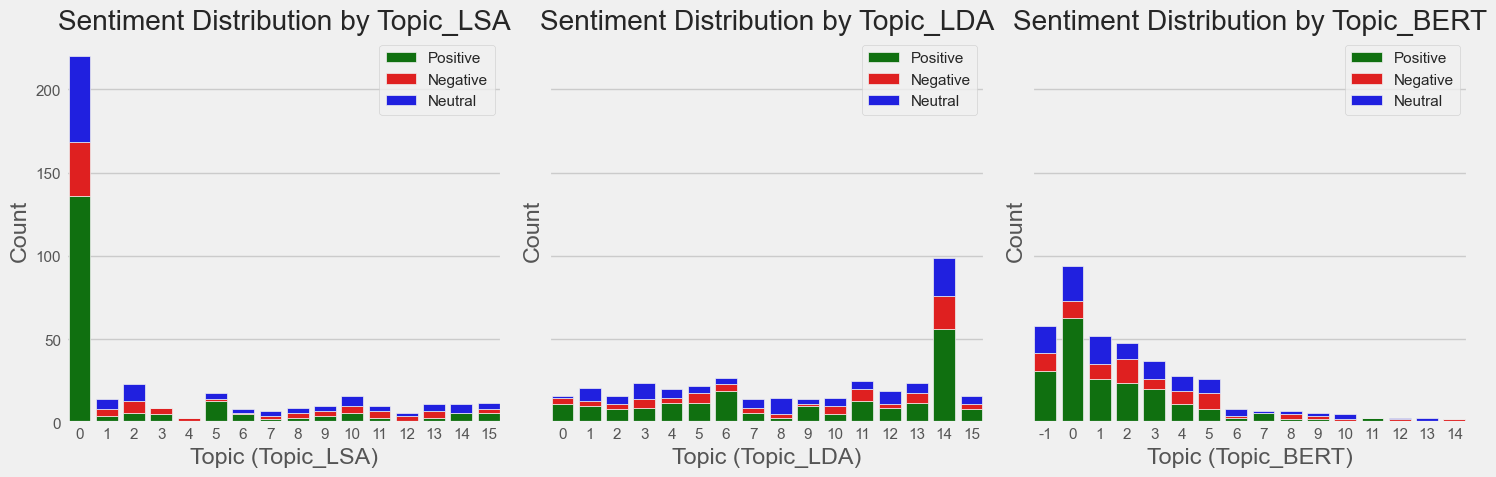

In [115]:
topics = ['Topic_LSA', 'Topic_LDA', 'Topic_BERT']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

for i, topic in enumerate(topics):
    df_grouped = df.groupby([topic, 'predicted sentiment']).size().unstack(fill_value=0)
    sns.barplot(x=df_grouped.index, y=df_grouped['positive'], label='Positive', color='green', ax=axes[i])
    sns.barplot(x=df_grouped.index, y=df_grouped['negative'], bottom=df_grouped['positive'], label='Negative', color='red', ax=axes[i])
    sns.barplot(x=df_grouped.index, y=df_grouped['neutral'], bottom=df_grouped['positive']+df_grouped['negative'], label='Neutral', color='blue', ax=axes[i])

    axes[i].set_xlabel(f'Topic ({topic})')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Sentiment Distribution by {topic}')
    axes[i].legend()


plt.tight_layout()
plt.show()

## Summary
Comparing the models that were created, it is visible that LSA did not catch the topics as good as BERTopic and LDA> In fact, BERTopic found a lot more similarities between the documents and created a good representation of the topics that were discussed in the reddit posts. It is also noticeable that mainly the sentiment in the posts is positive, and we have the smallest amount of neutral sentiment in the posts.